<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/VSI_5level_3phase_fluxTrajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

None
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0


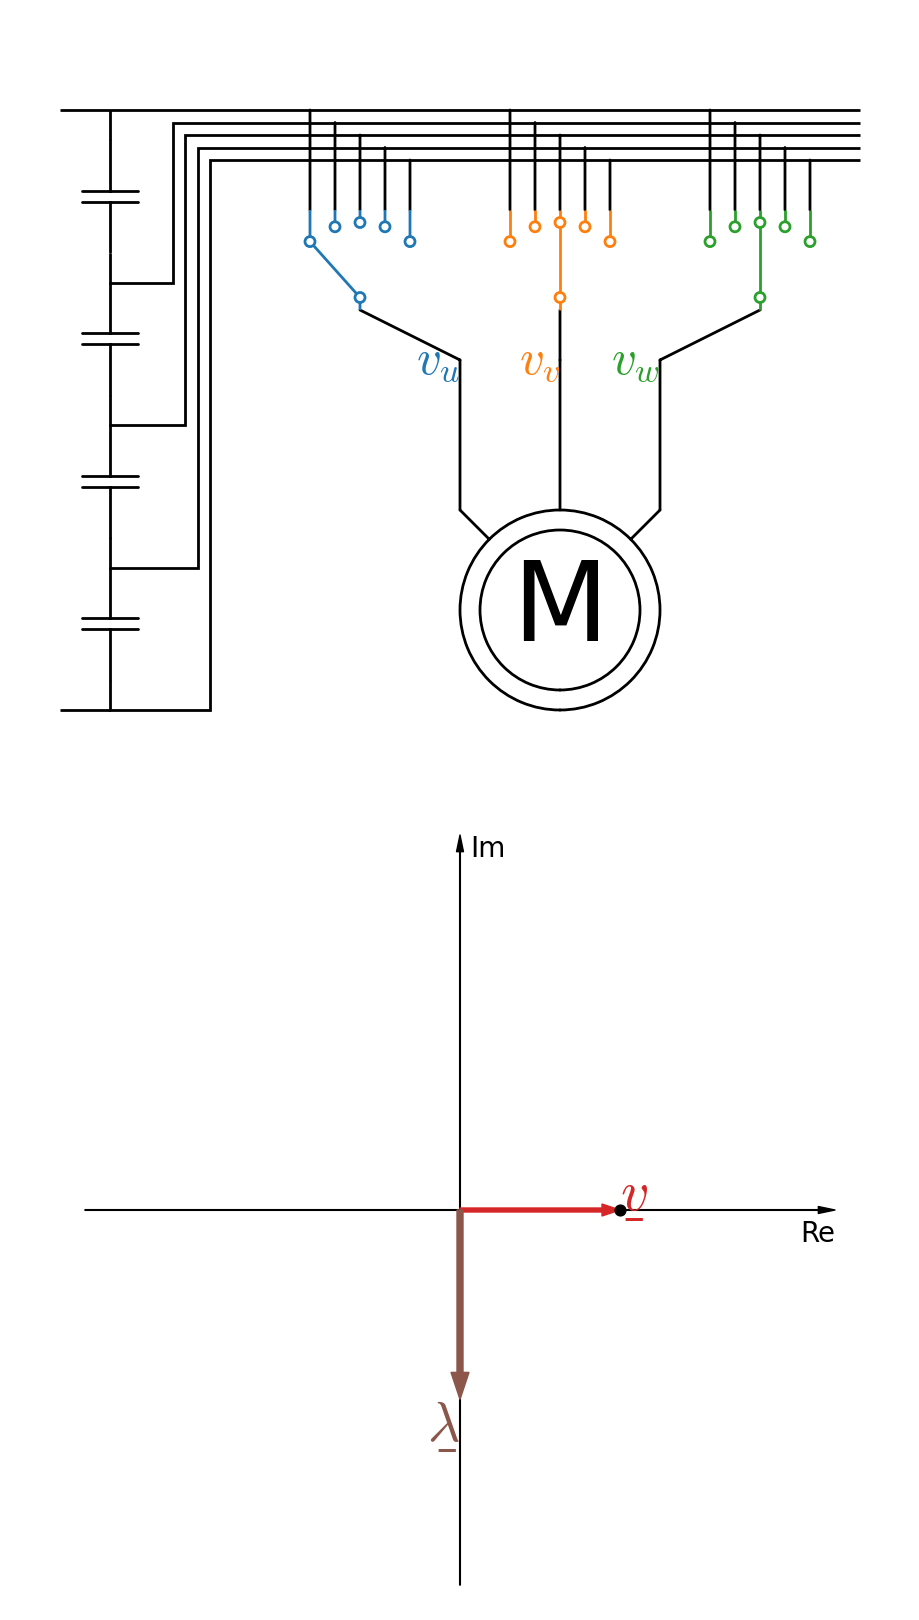

In [50]:
from os import linesep
import numpy as np
from numpy import linspace,cos,arccos,pi,exp
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.path import Path
from matplotlib import transforms,animation
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'font.family':"sans serif",'animation.html':'jshtml',"mathtext.fontset" : "cm"})

#carrier
def carrier(t,fs,n):
  return .25/pi*arccos(cos(2*pi*fs*t))+.25*n

#modulation functions
def mf_abc(t,f,MI,theta):
  mf=[]
  for i in range(3):
    mf.append(.5*MI*cos(2*pi*f*t+theta-i*2*pi/3)+.5)
  return np.array(mf)

#PWM voltage waveforms
def vac_abc(t,V,f,MI,theta,fs):
  vac=[]
  for i in range(3):
    n = (mf_abc(t,f,MI,theta)[i]/.25).astype(int)
    vac.append(V*(np.heaviside(mf_abc(t,f,MI,theta)[i]-carrier(t,fs,n),0)+n))
  return np.array(vac)

#integration of space vector
def sv_dt(t1,t2,V,f,MI,theta,fs):
  sv=0
  for i in range(3):
    v_dt = integrate.fixed_quad(lambda x: vac_abc(x,V,f,MI,theta,fs)[i],t1,t2)
    sv += 2/3*v_dt[0]*exp(1j*i*2*pi/3)
  if t1<3/600:
    print(v_dt[1])
  return sv

#draw single-pole-multiple-throw switch
def draw_spmt(ax,x0,y0,n=3,w=1,h=1,ss=0,theta=0,lw=2,color='k'):
    r=.75*w
    x00=x0+(w-r)/2
    rot = transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
    ax.add_patch(mp.Circle((x00,y0),.05,fc='w',ec=color,lw=lw,zorder=2,transform=rot))
    verts,codes=[(x0,y0),(x00,y0)],[]
    for k in range(n):
        dy=h/(n-1)*k
        dx=np.sqrt(r**2-(dy-.5*h)**2)
        ax.add_patch(mp.Circle((x00+dx,y0-.5*h+dy),.05,fc='w',ec=color,lw=lw,
                               zorder=2,transform=rot))
        verts+=[(x00+dx,y0-.5*h+dy),(x0+w,y0-.5*h+dy)]
        if k==ss:
            verts+=[(x00,y0),(x00+dx,y0-.5*h+dy)]
    codes+=[Path.MOVETO,Path.LINETO]*(n+2)
    ax.add_patch(mp.PathPatch(Path(verts,codes),lw=lw,color=color,transform=rot))
    return

#draw capacitor symbol
def draw_capacitor(ax,x0,y0,h=1,theta=0,lw=1,color='k',alpha=1):
    dx,dy = (.1*h, .25*h)
    verts = [(x0,y0),(x0+h/2-dx/2,y0),(x0+h/2-dx/2,y0+dy),(x0+h/2-dx/2,y0-dy),
             (x0+h,y0),(x0+h/2+dx/2,y0),(x0+h/2+dx/2,y0+dy),(x0+h/2+dx/2,y0-dy)]
    codes = [Path.MOVETO,Path.LINETO]*4
    rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
    ax.add_patch(mp.PathPatch(Path(verts,codes),ec=color,alpha=alpha,fc='None',
                              lw=lw,capstyle='round',transform=rot))
    return

#draw 3-phase motor symbol
def draw_motor_3phase(ax,x0,y0,h=1,theta=0,lw=1,color='k',alpha=1):
    verts = [(x0,y0+.5*h),(x0+.5*h-.25*np.sqrt(2)*h,y0+.25*np.sqrt(2)*h),
             (x0,y0-.5*h),(x0+.5*h-.25*np.sqrt(2)*h,y0-.25*np.sqrt(2)*h)]
    verts += list(Path.arc(0,360).vertices*.5*h+np.array([x0+.5*h,y0]))
    verts += list(Path.arc(0,360).vertices*.4*h+np.array([x0+.5*h,y0]))
    codes = [Path.MOVETO,Path.LINETO]*2 + list(Path.arc(0,360).codes)*2
    rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
    ax.add_patch(mp.PathPatch(Path(verts,codes),ec=color,alpha=alpha,fc='None',
                              lw=lw,capstyle='round',transform=rot))
    ax.text(x0+.5*h,y0,'M',size=40*h,va='center',ha='center',transform=rot)
    return

def draw_dc_link(ax,x0,y0,h=5,w=2,lw=1,nc=2,color='k'):
    if nc<4:
        hc = .2*h
    else:
        hc = h/nc*.75
    lcon = (h-nc*hc)/(nc+1)
    dx=.5
    verts = [(x0,y0+h/2),(x0+w,y0+h/2),(x0,y0-h/2),(x0+dx,y0-h/2),(x0+dx,y0+.5*h),(x0+dx,y0+.5*h-lcon)]
    codes = [Path.MOVETO,Path.LINETO]*3
    for k in range(nc):
        draw_capacitor(ax,x0+dx,y0-.5*h+k*hc+(k+1)*lcon,h=hc,lw=lw,theta=90)
        verts+=[(x0+dx,y0-.5*h+k*(hc+lcon)+lcon),(x0+dx,y0-.5*h+k*(hc+lcon)),(x0+1.5-.5*k/nc,y0-.5*h+k*(lcon+hc)),
               (x0+1.5-.5*k/nc,y0+.5*h-.5+.5*k/nc),(x0+w,y0+.5*h-.5+.5*k/nc),]
        codes+=[Path.MOVETO]+[Path.LINETO]*4
    ax.add_patch(mp.PathPatch(Path(verts,codes),lw=lw,fc='None'))
    return

#draw VSI bridge - animated part
def draw_vsi_bridge_anim(ax,x0,y0,h=5,w=3,ss=[1]*3,nl=6,lw=1,color=['k']*3):
    dx,dy=3,1
    for k in range(3):
        draw_spmt(ax,x0+dx+k*w/4,y0+dy,n=nl,ss=ss[k],theta=90,lw=lw,color=color[k])
    return

#draw VSI bridge - non-animate part
def draw_vsi_bridge_non_anim(ax,x0,y0,h=5,w=3,nl=6,lw=1,color=['k']*3):
    draw_dc_link(ax,x0,y0,nc=nl-1,h=h,w=w,lw=lw)
    dx,dy=3,1
    verts,codes=[],[]
    for k in range(3):
        ax.text(x0+dx+(k+1)*w/8,y0+dy-.5,['$v_u$','$v_v$','$v_w$'][k],size=35,color=color[k],ha='right',va='center')
        for kk in range(nl):
            verts+=[(x0+dx-.5+kk/(nl-1)+k*w/4,y0+dy+1),(x0+dx-.5+kk/(nl-1)+k*w/4,y0+.5*h-.5*kk/(nl-1)),]
        verts+=[(x0+dx+(k+1)*w/8,y0+dy-.5),(x0+dx+(k+1)*w/8,y0-1),]
        verts+=[(x0+dx+(k+1)*w/8,y0+dy-.5),(x0+dx+k*w/4,y0+dy),]
    codes+= [Path.MOVETO,Path.LINETO]*(3*nl+6)
    ax.add_patch(mp.PathPatch(Path(verts,codes),lw=lw,capstyle='round'))
    return

def draw_inverter_motor_non_anim(ax,x0,y0,h=7,w=8,nl=5,lw=2,color=['k']*3):
    draw_vsi_bridge_non_anim(ax,x0,y0,h=h,w=w,nl=nl,lw=lw,color=color)
    draw_motor_3phase(ax,x0+3+w/4,y0-1,h=w/4,theta=-90,lw=lw)
    return

def draw_xy_axes(ax,x0,y0,xlim=[0,1],ylim=[0,1],xlabel='',ylabel=''):
    ax.annotate("", xy=(xlim[1],y0),xytext=(xlim[0],y0),arrowprops=dict(headwidth=5,width=.5,color='k')) #x-axis
    ax.annotate("", xy=(x0,ylim[1]),xytext=(x0,ylim[0]),arrowprops=dict(headwidth=5,width=.5,color='k')) #y-axis
    ax.text(xlim[1],y0-.1,xlabel,size=20,va='top',ha='right')
    ax.text(x0+.1,ylim[1],ylabel,size=20,va='top',ha='left')
    return

def axis_reset(ax): #clear axis for redrawing
    xy=ax.axis(); ax.cla(); ax.axis('off'); ax.set(xlim=xy[:2],ylim=xy[-2:])
    return

def draw_space_vector(ax,x0,y0,sv,label='',color='k'):
    ax.annotate("", xy=(x0+sv.real,y0+sv.imag),xytext=(x0,y0),arrowprops=dict(headwidth=10,width=3,color=color))
    ax.text(x0+sv.real,y0+sv.imag,label,size=30,color=color,ha='right')
    return

def abc2sv(abc):
    sv=0
    for k in range(3):
        sv+=2/3*abc[k]*exp(1j*2*pi/3*k)
    return sv

#find the redundancy of v in list l
def redundancy(l,v):
    return len([x for x in l if abs(x-v)<1e-6])

#parameters
Nf = 900
f = 1/(2*pi) # fundamental frequency in Hz
T = 1/f #fundamental period
fs = 36*f #switching frequency
Ts = 1/fs #switching period

t=linspace(0,T,int(Nf))
wt = 2*pi*f*t
V = 1 #voltage
theta=0
MI=0.95 #modulation index
vabc_modulation=mf_abc(t,f,MI,theta)
vabc_pwm = vac_abc(t,V,f,MI,theta,fs)
v_sv = 2/3*(vabc_pwm[0]+vabc_pwm[1]*exp(1j*2*pi/3)+vabc_pwm[2]*exp(1j*4*pi/3))
lambda_sv=[0] #flux linkage
for i in range(1,Nf):
  lambda_sv.append(sv_dt(t[i-1],t[i],V,f,MI,theta,fs) + lambda_sv[-1])
lambda_sv=np.array(lambda_sv)
lambda_sv-=np.mean(lambda_sv)

cs = list(mpl.cm.tab10.colors) + ['w','k'] #color sequence
orientation = 'portrait'
# orientation = 'landscape'
if orientation == 'portrait':
    figsize=(9,16)
    xlim,ylim = [-4.5,4.5],[0,16]
    x0,y0=[-4,0],[12,4]
    w,h = 8,6
else:
    figsize=(16,9)
    xlim,ylim = [0,16],[-4.5,4.5]
    x0,y0=[7.75,4],[0,0]
    w,h = 8,8
fig = plt.figure(figsize=figsize) #portrait
ax0 = fig.add_axes((0,0,1,1),ylim=ylim,xlim=xlim ,fc='none')
ax1 = fig.add_axes((0,0,1,1),ylim=ylim,xlim=xlim ,fc='none')
ax0.axis('off')
lines_flux = ax0.plot([], [], '-', lw=5, color=cs[1])[0] #flux linkage trajectory
nl =5 #number of levels
ss = vabc_pwm
sv = abc2sv([ss[0,:],ss[1,:],ss[2,:]]) #space vectors corresponding to the switching states
vs = 1.2 #vector scale

def drawVectors(ax,x0,y0,lambda_sv,v_sv,vabc,clst):
  theta_v = np.angle(v_sv)
  if theta_v<0:
    theta_v = 2*pi+theta_v
  theta_l = np.angle(lambda_sv)
  if theta_l<0:
    theta_l = 2*pi+theta_l
  arr = mp.FancyArrow(x0,y0,v_sv.real, v_sv.imag, width=.04,length_includes_head=True,
                   color=clst[3]) #space vector v_sv
  ax.add_patch(arr)
  arr = mp.FancyArrow(x0,y0,lambda_sv.real, lambda_sv.imag, width=.06,length_includes_head=True,
                   color=clst[5]) #space vector lambda_sv
  ax.add_patch(arr)
  t1 = ax.text(x0+v_sv.real,y0+v_sv.imag,r'$v\underbar$', size = 40, color=clst[3])
  if theta_v>pi/2 and theta_v<3*pi/2:
    t1.set_ha('right')
  if theta>pi:
    t1.set_va('top')
  t2 = ax.text(x0+lambda_sv.real,y0+lambda_sv.imag,r'$\lambda\underbar$', size = 40, color=clst[5])
  if theta_l>pi/2 and theta_l<3*pi/2:
    t2.set_ha('right')
  if theta_l>pi:
    t2.set_va('top')
  return

def animate(i):
    # i=100
    if i%50==0:
      print(i) #for monitoring
    lines_flux.set_data(x0[1]+lambda_sv[:i+1].real,y0[1]+lambda_sv[:i+1].imag) #flux linkage trajectory
    axis_reset(ax1)
    draw_vsi_bridge_anim(ax1,x0[0],y0[0],h=h,w=w,nl=nl,ss=ss[:,i],lw=2,color=cs)
    drawVectors(ax1,x0[1],y0[1],lambda_sv[i],vs*sv[i],vabc_pwm[:,i],cs)
    ax1.scatter(x0[1]+vs*sv[:i+1].real,y0[1]+vs*sv[:i+1].imag,marker='o',s=60,color='k')
    return

draw_xy_axes(ax0,x0[1],y0[1],xlim=[x0[1]-3.75,x0[1]+3.75],ylim=[y0[1]-3.75,y0[1]+3.75],xlabel='Re',ylabel='Im')
draw_inverter_motor_non_anim(ax0,x0[0],y0[0],h=h,w=w,nl=nl,lw=2,color=cs)
# with PdfPages("VSI_5level_switchingStates.pdf") as pdf: #save to pdf
#     for k in range(nl**3):
#         animate(k)
#         pdf.savefig()
anim = animation.FuncAnimation(fig, animate, interval=1000, frames=Nf)
# anim
anim.save("mlc_5lv_fluxTrajectory.mp4", writer=animation.FFMpegWriter(fps=30), dpi=200)
